Trying an idea of mine that starts with a denoising autoencoder trained on lung segmentations.

In [6]:
import monai
from util import MasksToOneHotD
import matplotlib.pyplot as plt
import numpy as np
import torch
import os, glob

monai.utils.misc.set_determinism(seed=9274)

In [7]:
dataset_base_path = '/home/ebrahim/data/chest_xrays/MontgomerySet'
dataset_imgs_path = os.path.join(dataset_base_path, 'CXR_png/')
dataset_seg_path_left = os.path.join(dataset_base_path, 'ManualMask/leftMask')
dataset_seg_path_right = os.path.join(dataset_base_path, 'ManualMask/rightMask')

imgs = glob.glob(os.path.join(dataset_imgs_path, '*.png'))
segs_left = glob.glob(os.path.join(dataset_seg_path_left, '*.png'))
segs_right = glob.glob(os.path.join(dataset_seg_path_right, '*.png'))

file_path_to_ID = lambda p : os.path.basename(p)[7:11]
file_path_to_abnormality = lambda p : bool(int(os.path.basename(p)[12]))

img_ids = list(map(file_path_to_ID,imgs));
seg_ids_left = list(map(file_path_to_ID,segs_left));
seg_ids_right = list(map(file_path_to_ID,segs_right));

data = []
for img in imgs:
    img_id = file_path_to_ID(img)
    seg_left = segs_left[seg_ids_left.index(img_id)]
    seg_right = segs_right[seg_ids_right.index(img_id)]
    tuberculosis = file_path_to_abnormality(img)
    data.append({
        'img' : img,
        'seg_left' : seg_left,
        'seg_right' : seg_right,
        'tuberculosis' : tuberculosis

    })

data_train, data_valid = monai.data.utils.partition_dataset_classes(
    data,
    classes = list(map(lambda d : d['tuberculosis'], data)),
    ratios = (8,2)
)

# Autoencoder part

In [375]:
image_size = 256

transform_valid = monai.transforms.Compose([
    monai.transforms.LoadImageD(keys = ['seg_left', 'seg_right'], dtype="int8"),
    monai.transforms.TransposeD(keys = ['seg_left', 'seg_right'], indices = (1,0)),
    MasksToOneHotD(
        keys = ['seg_left', 'seg_right'],
        keyList = ['seg_left', 'seg_right'],
        newKeyName = 'seg'
    ),
    monai.transforms.DeleteItemsD(keys = ['seg_left', 'seg_right']),
    monai.transforms.ResizeD(
        keys = ['seg'],
        spatial_size=(image_size,image_size),
        mode = 'nearest'
    ),
    monai.transforms.ToTensorD(keys = ['seg']),
])

transform_train = monai.transforms.Compose([
    transform_valid,
    monai.transforms.CopyItemsD(keys=['seg'],times=1,names=['seg_noised']),
    monai.transforms.RandCoarseDropoutd(
        keys = ['seg_noised'],
        holes = 1,
        max_holes=5,
        spatial_size=16,
        max_spatial_size=128,
        prob=0.,
        fill_value=255
    ),
    monai.transforms.RandRotateD(
        keys = ['seg_noised', 'seg'],
        mode = 'nearest',
        prob=1.,
        range_x = np.pi/16,
        padding_mode="zeros",
    ),
    monai.transforms.RandZoomD(
        keys = ['seg_noised', 'seg'],
        mode = 'nearest',
        prob=1.,
        padding_mode="constant",
        min_zoom = 0.7,
        max_zoom=1.3,
    ),
    monai.transforms.RandLambdaD(
        keys=['seg_noised'],
        func=torch.nn.Dropout(p=0.5)
    )
])

In [376]:
dataset_train = monai.data.Dataset(data_train, transform_train)
dataset_valid = monai.data.Dataset(data_valid, transform_valid)

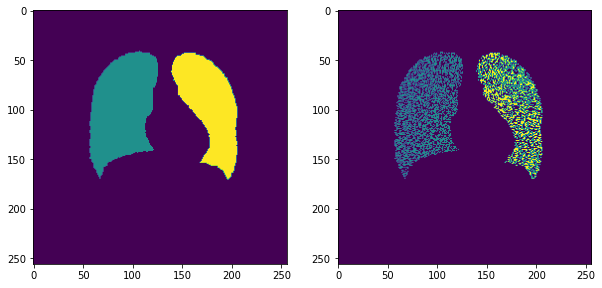

In [396]:
# verify that transforms are working properly

d = dataset_train[2]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(d['seg'].argmax(dim=0))
ax2.imshow(d['seg_noised'].argmax(dim=0))
plt.show()

In [390]:
ae = monai.networks.nets.AutoEncoder(
    spatial_dims=2,
    in_channels=2,
    out_channels=2,
    channels=(2, 4, 8, 8, 8, 8),
    strides=(2, 2, 2, 2, 2, 2)
)

In [391]:
ae

AutoEncoder(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_3): Convolution(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): Instan